gnjgnioniogneiogeergnieginogrignigreio
26


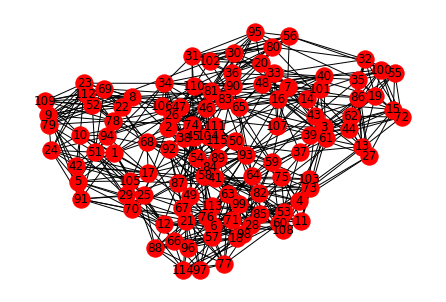

In [3]:
import networkx as nx
import numpy as np
import pandas as pd








def community_detection(nodes,edges,population=15,generation=30,r=1.5):
    
    graph=nx.Graph() 
    graph.add_nodes_from(nodes) #adds nodes
    graph.add_edges_from(edges) #add edges
    Adj = nx.adjacency_matrix(graph) 
   
    nodes_length = len(graph.nodes())
    nx.draw(graph, with_labels=True,node_color = "red")
    # Generates chromosomes? basically gives chrom array population value times
    d = {"chrom":[generate_chrom(nodes_length,Adj) for n in range(population)]}
      
    #makes data frame of data set d
    dframe = pd.DataFrame(data= d)
    
    
    dframe["subsets"] = dframe["chrom"].apply(find_subsets)
#     print(dframe["subsets"])
    dframe["community_score"]=dframe.apply(lambda x: community_score(x["chrom"],x["subsets"],r,Adj),axis=1)
   # print('commscore: ',dframe["community_score"])
    
    
    gen = 0
    population_count = population
    while gen < generation:
       # print('\n\n\n\ngen', gen,'\n')
        for i in range(int(np.floor(population/10))):
            p1 = 0
            p2 = 0
            elites = dframe.sort_values("community_score",ascending=True)[int(np.floor(population/10)):]
            p1 = roulette_selection(elites)
            p2 = roulette_selection(elites)
            child=uniform_crossover(dframe["chrom"][p1],dframe["chrom"][p2],0.8)
            if len(child)==0:
                continue
            child=mutation(child,Adj,0.2)
            child_subsets = find_subsets(child)
            child_cs = community_score(child,child_subsets,r,Adj)
            dframe.loc[population_count]=[child,child_subsets,child_cs]
            population_count += 1
        dfsorted = dframe.sort_values("community_score",ascending=False)
        to_drop = dfsorted.index[population:]
        dframe.drop(to_drop,inplace=True)
        gen +=1   
#         print(dframe)
#         print(dfsorted)
        
    sorted_df = dframe.sort_values("community_score",ascending=False).index[0]
    print('gnjgnioniogneiogeergnieginogrignigreio')
    print(sorted_df)
    nodes_subsets = dframe["subsets"][sorted_df]
    nodes_list = list(graph.nodes())
    result = []
    #print('nodeslist',nodes_list)
    for subs in nodes_subsets:
        subset = []
        for n in subs:
            subset.append(nodes_list[n])
        #print(subset)
        result.append(subset)
#     colors = ['red','blue','green','yellow','pink','orange','cyan','purple','grey','brown','olive','indigo','yellowgreen','chocolate']
#     alreadyvisited = []
#     k = 0 
#     colormap = ['']*result.size()
#     for i in result:
#         for j in i:
#             if j not in alreadyvisited:
#                 colormap[j] = colors[k]
#                 alreadyvisited.append(j)
#             else:
#                 colormap[j]=  'white'
#             j=j+1
#         k=k+1
#         i=i+1
#     nx.draw(graph,node_color = colormap , with_label = True)
#     plt.show()
    
    return result


# returning the the array of column indexes where randomly chosen till value is 1 
def generate_chrom(nodes_length,Adj):
    chrom = np.array([],dtype=int)
    for x in range(nodes_length):
        rand = np.random.randint(0,nodes_length)
        while Adj[x,rand] != 1:
            rand = np.random.randint(0,nodes_length)
        chrom = np.append(chrom,rand)
    return chrom



def merge_subsets(sub):
    arr =[]
    to_skip=[]
    for s in range(len(sub)):
        if sub[s] not in to_skip:
            new = sub[s]
            for x in sub:
                if sub[s] & x:
                    new = new | x
                    to_skip.append(x)
            arr.append(new)
    return arr

def find_subsets(chrom):
    sub = [{x,chrom[x]} for x in range(len(chrom))]
    result=sub
    i=0
    while i<len(result):
        candidate = merge_subsets(result)
        if candidate != result:
            result = candidate
        else:
            break
        result=candidate
        i+=1
    return result

def community_score(chrom,subsets,r,Adj):
    matrix = Adj.toarray()
    CS=0
    for s in subsets:
        submatrix = np.zeros((len(chrom),len(chrom)),dtype=int)
        for i in s:
            for j in s:
                submatrix[i][j]=matrix[i][j]
        M=0
        v=0
        PS=0
        for row in list(s):
            ki = np.sum(matrix[row])
            kiin = np.sum(submatrix[row])
            kiout = ki - kiin
            P= kiin/ki
            PS+=P
            row_mean = kiin/len(s)
            v+=np.sum(submatrix[row])
            M+=(row_mean**r)/len(s)
        CS+=M*v
    OS= 0.5*CS/len(subsets) + 0.5*(1/PS)*len(subsets)  #Overall score is calculated by maximizing CS and min PS
    #OS= 0.5*CS + 0.5*(1/PS)  #Overall score is calculated by maximizing CS and min PS

#     print(OS)
    return OS

def roulette_selection(df_elites):
    prob = np.random.random_sample()
#     print('prob',prob)
    sum_cs=np.sum(df_elites["community_score"])
#     print(sum_cs)
    x=0
    selected = 0
    for i in df_elites.index:
        x += df_elites["community_score"][i]
            
        X=x/sum_cs
#         print('X',X)
        if prob < X:
            chosen=i
            break
    return chosen

def uniform_crossover(parent_1,parent_2,crossover_rate):
    if np.random.random_sample() < crossover_rate:
        length = len(parent_1)
        mask = np.random.randint(2, size=length)
        child = np.zeros(length,dtype=int)
        for i in range(len(mask)):
            if mask[i] == 1:
                child[i]=parent_1[i]
            else:
                child[i]=parent_2[i]
        return child
    else:
        return np.array([])

def mutation(chrom,Adj,mutation_rate):
    if np.random.random_sample() < mutation_rate:
        chrom = chrom
        neighbor = []
        while len(neighbor) < 2:
            mutant = np.random.randint(1,len(chrom))
            row = Adj[mutant].toarray()[0]
            neighbor = [i for i in range(len(row)) if row[i]==1]
            if len(neighbor) > 1:
                neighbor.remove(chrom[mutant])
                to_change=int(np.floor(np.random.random_sample()*(len(neighbor))))
                chrom[mutant]=neighbor[to_change]
                neighbor.append(chrom[mutant])
    return chrom

nodes = []
edges = np.loadtxt('football.txt')
for i in edges:
    for j in i:
        if j not in nodes:
            nodes.append(int(j))
    

# print(nodes)
arr = community_detection(nodes,edges)


# print(arr)



#nx.draw_networkx_nodes(graph, arr[0], node_color="tab:blue")

[[1. 5.]
 [2. 6.]
 [3. 7.]]


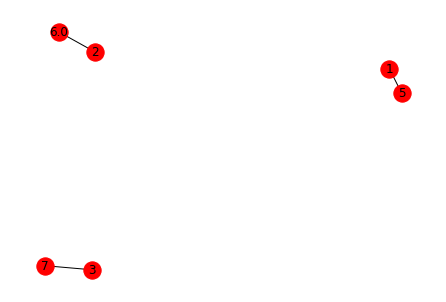

In [14]:
edges = np.loadtxt('abc.txt')
nodes = [1 ,2, 3 , 5, 7]
print(edges)
graph=nx.Graph() 
graph.add_nodes_from(nodes) #adds nodes
graph.add_edges_from(edges) #add edges
Adj = nx.adjacency_matrix(graph) 
nodes_length = len(graph.nodes())
nx.draw(graph, with_labels=True,node_color = "red")


In [ ]:
colors = ['red','blue','green','yellow','pink','orange','cyan','purple','grey','brown','olive','indigo','yellowgreen','chocolate']
alreadyvisited = []
k = 0 
colormap = [NULL]*arr.size()
for i in arr:
    for j in i:
        if j not in alreadyvisited:
            colormap[j] = colors[k]
            alreadyvisited.append(j)
        else:
            colormap[j]=  'white'
        j++
    k++
    i++
nx.draw(graph,node_color = colormap , with_label = True)
plt.show()